In [1]:
import numpy as np
import pandas as pd
from Evaluator import ModelEvaluator
import torch
import random
from matplotlib import pylab as plt
from IPython.display import clear_output

In [2]:
data=pd.read_csv('datasets/malicious_data_generated.csv')
npdata=data.to_numpy()
malData=np.copy(npdata)
print(type(malData[1,:]))
print(malData[:1].shape)

<class 'numpy.ndarray'>
(1, 10)


In [9]:
features=['A','B','C','D','F','G','H','I','j','k']

In [3]:
class MalwareEnv():
    def __init__(self):
        # Actions we can take, decrease, increse
        self.action_space = 20  
        # Set start 
        self.state = np.asarray(malData[random.randint(0,498),:])
        #model to evaluate the reward
        self.evaluator=ModelEvaluator()
        #units to move
        self.block=10
        #save the last 500 items
        
    def step(self, action):
        
        if(action<9):
            self.state[action]+=self.block
        elif(action>=9 and action<19):
            self.state[action-9]-=self.block
            
        
    def reward(self):
        reward=-1
        value=self.state.tolist()
        result=self.evaluator.test(value)
        result=np.array2string(result)
        
        if(result=="['benign']"):
                 reward=+10
                 
        return reward    
    
    def saveItem(self):
        df=pd.DataFrame(columns=features)

    def render_np(self):
        return self.state
    

In [4]:


l1 = 10
l2 = 24
l3 = 72
l4 = 20
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
#device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.cuda()
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
gamma = 0.9
epsilon = 1.0

In [5]:
epochs = 1500
losses = [] 

for i in range(epochs): 
    env = MalwareEnv() 
    state_ = env.render_np().reshape(1,10) + np.random.rand(1,10)/50.0 
    state1 = torch.from_numpy(state_).float() 
    status = 1 
    while(status == 1): 
        qval = model(state1.cuda()) 
        qval_ = qval.data.cpu().numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,20)
        else:
            action_ = np.argmax(qval_)
        
        env.step(action_) 
        state2_ = env.render_np().reshape(1,10) + np.random.rand(1,10)/50.0
        state2 = torch.from_numpy(state2_).float() 
        reward = env.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,10).cuda())
        maxQ = torch.max(newQ) 
        if reward == -1: 
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] 
        loss = loss_fn(X.cuda(), Y.cuda()) 
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: 
            status = 0
    if epsilon > 0.1: 
        epsilon -= (1/epochs)

1499 1.0418274402618408


D:\programas\anaco\envs\latest tf 101021\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [6]:
losses
#clear_output(wait=True)

[76.35140991210938,
 83.83145141601562,
 66.61943817138672,
 52.958866119384766,
 42.01821517944336,
 7.031905174255371,
 38.04398727416992,
 80.59828186035156,
 53.81595230102539,
 59.04159927368164,
 30.389799118041992,
 51.03401184082031,
 11.984091758728027,
 33.310630798339844,
 39.272212982177734,
 52.23881149291992,
 36.353607177734375,
 32.44747543334961,
 0.6646099090576172,
 42.27515411376953,
 41.850921630859375,
 55.176658630371094,
 1.4395005702972412,
 3.1023426055908203,
 46.81989288330078,
 15.09514045715332,
 40.275089263916016,
 0.6419793963432312,
 1.3464692831039429,
 12.99327278137207,
 0.6901566386222839,
 11.137335777282715,
 2.525951623916626,
 0.6343130469322205,
 94.87320709228516,
 263.0360412597656,
 79.71550750732422,
 62.897438049316406,
 86.77650451660156,
 0.12603077292442322,
 78.34220886230469,
 5.993207931518555,
 319.65814208984375,
 9.871452331542969,
 8.034591674804688,
 164.47744750976562,
 93.12689208984375,
 32.787811279296875,
 37.1948471069335

Text(0, 0.5, 'Loss')

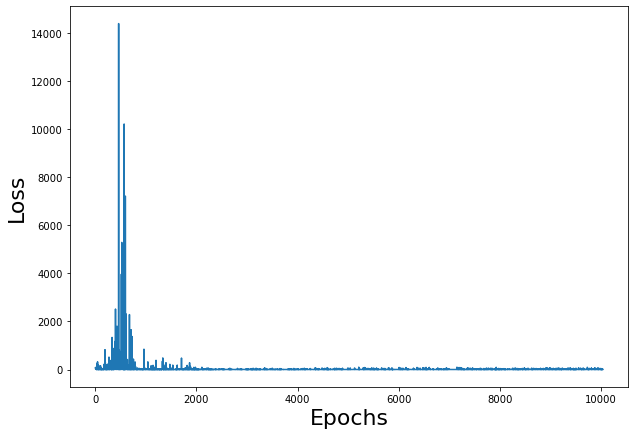

In [7]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [8]:
torch.save(model.state_dict(), 'DRLMalwareModificator.sav')